In [153]:
import os
import numpy as np

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import pickle
import openpyxl

from matplotlib.colors import ListedColormap,Normalize,BoundaryNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [7]:
data_path = os.path.join('C:\\','data')
output_path = os.path.join('C:\\','projects','pg_risk_analysis','output')
risk_path = os.path.join(output_path,'risk')
figure_path = os.path.join('C:\\','projects','pg_risk_analysis','figures')

# Load datasets with additional information about countries to create the maps

In [85]:
ne_countries = gpd.read_file(os.path.join(data_path,'natural_earth','ne_10m_admin_0_countries.shp'))
ne_sindex = ne_countries.sindex
#incomegroups = pd.read_csv(os.path.join(data_path,'input_data','incomegroups_2018.csv'),index_col=[0])

# Read and restructure risk results

## Read risk results

In [13]:
def read_risk(hazard_type,infra_type):
    """
    Read the risk results of historical (FL) and present (TC) climate model
    """
    outputs = {}
    for risk_output in os.listdir(risk_path):
        climate_model = os.path.splitext(risk_output)[0].split('_')[3]
        if (hazard_type in risk_output) & (infra_type in risk_output) & (climate_model in risk_output):
            check_sheets = pd.ExcelFile(os.path.join(risk_path,risk_output),engine='openpyxl').sheet_names
            for sheet in check_sheets:
                out = pd.read_excel(os.path.join(risk_path,risk_output),sheet_name= sheet, index_col=[0],engine='openpyxl')
                outputs[risk_output[:3],climate_model,sheet] = out
    df = pd.concat(outputs).unstack(level=2).dropna(axis=1, how='all')
    #df.to_csv(os.path.join(output_path,'{}_risk.csv'.format(hazard_type)))
    
    return df

## Read and restructure osm historical risk of coastal flood/tropical cyclone

In [115]:
def hist_risk(hazard_type):
    df = read_risk(hazard_type,'osm')
    
    # country_codes does not include SGP
    country_codes = ['BRN','CHN','IDN','JPN','LAO','MYS','MNG','MMR','PRK','PHL','KHM','KOR','TWN','THA','VNM'] #ADD CHN!!!!!!!!
       
    reframe_risk = {}
    model_risk = {}
    risk_result = {}
    
    if hazard_type == 'fl':
        for country_code in country_codes:
            # for climate_model in climate_models:
            reframe_risk[country_code] = df.unstack(level=-1).T.unstack(level=-1)[country_code]
            #reframe_risk[country_code].drop('rcp8p5',axis=1)
            #print(reframe_risk[country_code])

            model_risk[country_code] = reframe_risk[country_code]['historical'].reset_index()
            #print(model_risk[country_code])
            model_risk[country_code] = model_risk[country_code].rename(columns={'level_0':'curve_code', 'level_1':'asset_type'})
            model_risk[country_code]['country_code'] = country_code
            model_risk[country_code]['climate_model'] = 'historical'
            model_risk[country_code]['infra_type'] = 'osm'

            df_risk_result = pd.concat(model_risk.values(), keys=model_risk.keys())
            risk_result = pd.concat([df_risk_result])
            #risk_result[climate_model] = risk_result[climate_model][risk_result[climate_model]['climate_model'] == climate_model]
    elif hazard_type == 'tc':
        for country_code in country_codes:
            # for climate_model in climate_models:
            reframe_risk[country_code] = df.unstack(level=-1).T.unstack(level=-1)[country_code]
            #reframe_risk[country_code].drop('rcp8p5',axis=1)
            #print(reframe_risk[country_code])

            model_risk[country_code] = reframe_risk[country_code]['present'].reset_index()
            #print(model_risk[country_code])
            model_risk[country_code] = model_risk[country_code].rename(columns={'level_0':'curve_code', 'level_1':'asset_type'})
            model_risk[country_code]['country_code'] = country_code
            model_risk[country_code]['climate_model'] = 'present'
            model_risk[country_code]['infra_type'] = 'osm'

            df_risk_result = pd.concat(model_risk.values(), keys=model_risk.keys())
            risk_result = pd.concat([df_risk_result])
            
    return risk_result

In [111]:
hist_risk('fl')

0      curve_code  asset_type     mean_risk   lower_risk    upper_risk   
BRN 0      F5_1_1   line_risk           NaN          NaN           NaN  \
    1      F5_1_2   line_risk           NaN          NaN           NaN   
    2      F5_1_3   line_risk           NaN          NaN           NaN   
    3      F5_1_4   line_risk           NaN          NaN           NaN   
    4      F5_1_5   line_risk           NaN          NaN           NaN   
...           ...         ...           ...          ...           ...   
VNM 19     F3_1_2  tower_risk  10814.996324  8111.247243  13518.745404   
    20     F4_1_1   pole_risk           NaN          NaN           NaN   
    21     F4_1_2   pole_risk           NaN          NaN           NaN   
    22     F4_1_3   pole_risk           NaN          NaN           NaN   
    23     F4_1_4   pole_risk           NaN          NaN           NaN   

0      country_code climate_model infra_type  
BRN 0           BRN    historical        osm  
    1           BRN    historical        osm  
    2           BRN    historical        osm  
    3           BRN    historical        osm  
    4           BRN    historical        osm  
...             ...           ...        ...  
VNM 19          VNM    historical        osm  
    20          VNM    historical        osm  
    21          VNM    historical        osm  
    22          VNM    historical        osm  
    23          VNM    historical        osm  

[360 rows x 8 columns]

In [112]:
# calculate FL osm hist mean risk for each infrastructure type
df = hist_risk('fl')[['country_code','asset_type','mean_risk']]

fl_hist_risk = pd.DataFrame(columns=['country_code', 'asset_type', 'mean_risk'])

# Group df according to the country code and asset type, and calculate the mean value of all mean risks for each infrastructure type
grouped_df = df.groupby(['country_code', 'asset_type'])['mean_risk'].mean().reset_index()

fl_hist_risk['country_code'] = grouped_df['country_code']
fl_hist_risk['asset_type'] = grouped_df['asset_type']
fl_hist_risk['mean_risk'] = grouped_df['mean_risk']
fl_hist_risk['climate_model'] = 'historical'

fl_hist_risk

,country_code,asset_type,mean_risk,climate_model
0,BRN,line_risk,NaN,historical
1,BRN,plant_risk,NaN,historical
2,BRN,pole_risk,NaN,historical
3,BRN,substation_risk,NaN,historical
4,BRN,tower_risk,NaN,historical
...,...,...,...,...
70,VNM,line_risk,5.117191e+04,historical
71,VNM,plant_risk,1.662761e+07,historical
72,VNM,pole_risk,NaN,historical
73,VNM,substation_risk,1.639356e+03,historical


In [113]:
# calculate FL osm hist sum risk for each country
sum_fl_hist_risk = pd.DataFrame(columns=['country_code', 'climate_model', 'sum_risk'])

grouped_fl_hist_risk = fl_hist_risk.groupby('country_code')['mean_risk'].sum().reset_index()

sum_fl_hist_risk['country_code'] = grouped_fl_hist_risk['country_code']
sum_fl_hist_risk['sum_risk'] = grouped_fl_hist_risk['mean_risk']
sum_fl_hist_risk['climate_model'] = fl_hist_risk.groupby('country_code')['climate_model'].first().values

sum_fl_hist_risk

,country_code,climate_model,sum_risk
0,BRN,historical,0.000000e+00
1,CHN,historical,9.009527e+08
2,IDN,historical,3.157823e+07
3,JPN,historical,1.589489e+09
4,KHM,historical,0.000000e+00
5,KOR,historical,3.496957e+08
6,LAO,historical,0.000000e+00
7,MMR,historical,5.442522e+04
8,MNG,historical,0.000000e+00
9,MYS,historical,9.325174e+06


## Read tc hist risk

In [116]:
# calculate FL osm hist mean risk for each infrastructure type
df = hist_risk('tc')[['country_code','asset_type','mean_risk']]

tc_hist_risk = pd.DataFrame(columns=['country_code', 'asset_type', 'mean_risk'])

# Group df according to the country code and asset type, and calculate the mean value of all mean risks for each infrastructure type
grouped_df = df.groupby(['country_code', 'asset_type'])['mean_risk'].mean().reset_index()

tc_hist_risk['country_code'] = grouped_df['country_code']
tc_hist_risk['asset_type'] = grouped_df['asset_type']
tc_hist_risk['mean_risk'] = grouped_df['mean_risk']
tc_hist_risk['climate_model'] = 'present'

tc_hist_risk

,country_code,asset_type,mean_risk,climate_model
0,BRN,line_risk,NaN,present
1,BRN,pole_risk,NaN,present
2,BRN,substation_risk,8.076186e+04,present
3,BRN,tower_risk,NaN,present
4,CHN,line_risk,7.731197e+09,present
5,CHN,pole_risk,2.817593e+06,present
6,CHN,substation_risk,9.663723e+06,present
7,CHN,tower_risk,4.311845e+08,present
8,IDN,line_risk,1.248573e+08,present
9,IDN,pole_risk,1.010547e+05,present


In [117]:
# calculate FL osm hist sum risk for each country
sum_tc_hist_risk = pd.DataFrame(columns=['country_code', 'climate_model', 'sum_risk'])

grouped_tc_hist_risk = tc_hist_risk.groupby('country_code')['mean_risk'].sum().reset_index()

sum_tc_hist_risk['country_code'] = grouped_tc_hist_risk['country_code']
sum_tc_hist_risk['sum_risk'] = grouped_tc_hist_risk['mean_risk']
sum_tc_hist_risk['climate_model'] = tc_hist_risk.groupby('country_code')['climate_model'].first().values

sum_tc_hist_risk

,country_code,climate_model,sum_risk
0,BRN,present,8.076186e+04
1,CHN,present,8.174863e+09
2,IDN,present,1.495002e+08
3,JPN,present,1.111510e+10
4,KHM,present,6.173831e+06
5,KOR,present,1.874807e+09
6,LAO,present,3.673431e+07
7,MMR,present,1.583152e+07
8,MNG,present,9.728763e+06
9,MYS,present,4.521421e+07


## Read fl rcp8p5 risk of coastal flood

In [96]:
def fl_rcp_risk(hazard_type):
    df = read_risk(hazard_type,'osm')
    
    # country_codes does not include SGP
    country_codes = ['BRN','CHN','IDN','JPN','LAO','MYS','MNG','MMR','PRK','PHL','KHM','KOR','TWN','THA','VNM']
    
    reframe_risk = {}
    model_risk = {}
    risk_result = {}
    
    for country_code in country_codes:
        # for climate_model in climate_models:
        reframe_risk[country_code] = df.unstack(level=-1).T.unstack(level=-1)[country_code]
        #reframe_risk[country_code].drop('rcp8p5',axis=1)
        #print(reframe_risk[country_code])

        model_risk[country_code] = reframe_risk[country_code]['rcp8p5'].reset_index()
        #print(model_risk[country_code])
        model_risk[country_code] = model_risk[country_code].rename(columns={'level_0':'curve_code', 'level_1':'asset_type'})
        model_risk[country_code]['country_code'] = country_code
        model_risk[country_code]['climate_model'] = 'rcp8p5'
        model_risk[country_code]['infra_type'] = 'osm'

        df_risk_result = pd.concat(model_risk.values(), keys=model_risk.keys())
        risk_result = pd.concat([df_risk_result])
        #risk_result[climate_model] = risk_result[climate_model][risk_result[climate_model]['climate_model'] == climate_model]
    
    return risk_result

In [97]:
fl_rcp_risk('fl')

0      curve_code  asset_type     mean_risk    lower_risk    upper_risk   
BRN 0      F5_1_1   line_risk           NaN           NaN           NaN  \
    1      F5_1_2   line_risk           NaN           NaN           NaN   
    2      F5_1_3   line_risk           NaN           NaN           NaN   
    3      F5_1_4   line_risk           NaN           NaN           NaN   
    4      F5_1_5   line_risk           NaN           NaN           NaN   
...           ...         ...           ...           ...           ...   
VNM 19     F3_1_2  tower_risk  14292.209748  10719.157311  17865.262185   
    20     F4_1_1   pole_risk           NaN           NaN           NaN   
    21     F4_1_2   pole_risk           NaN           NaN           NaN   
    22     F4_1_3   pole_risk           NaN           NaN           NaN   
    23     F4_1_4   pole_risk           NaN           NaN           NaN   

0      country_code climate_model infra_type  
BRN 0           BRN        rcp8p5        osm  
    1           BRN        rcp8p5        osm  
    2           BRN        rcp8p5        osm  
    3           BRN        rcp8p5        osm  
    4           BRN        rcp8p5        osm  
...             ...           ...        ...  
VNM 19          VNM        rcp8p5        osm  
    20          VNM        rcp8p5        osm  
    21          VNM        rcp8p5        osm  
    22          VNM        rcp8p5        osm  
    23          VNM        rcp8p5        osm  

[360 rows x 8 columns]

In [98]:
# calculate FL osm rcp mean risk for each infrastructure type
df = fl_rcp_risk('fl')[['country_code','asset_type','mean_risk']]

fl_rcp_risk = pd.DataFrame(columns=['country_code', 'asset_type', 'mean_risk'])

# Group df according to the country code and asset type, and calculate the mean value of all mean risks for each infrastructure type
grouped_df = df.groupby(['country_code', 'asset_type'])['mean_risk'].mean().reset_index()

fl_rcp_risk['country_code'] = grouped_df['country_code']
fl_rcp_risk['asset_type'] = grouped_df['asset_type']
fl_rcp_risk['mean_risk'] = grouped_df['mean_risk']
fl_rcp_risk['climate_model'] = 'rcp8p5'

fl_rcp_risk

,country_code,asset_type,mean_risk,climate_model
0,BRN,line_risk,NaN,rcp8p5
1,BRN,plant_risk,NaN,rcp8p5
2,BRN,pole_risk,NaN,rcp8p5
3,BRN,substation_risk,NaN,rcp8p5
4,BRN,tower_risk,NaN,rcp8p5
...,...,...,...,...
70,VNM,line_risk,6.685618e+04,rcp8p5
71,VNM,plant_risk,1.946142e+07,rcp8p5
72,VNM,pole_risk,NaN,rcp8p5
73,VNM,substation_risk,3.041150e+03,rcp8p5


In [99]:
# calculate FL fl rcp sum risk for each country
sum_fl_rcp_risk = pd.DataFrame(columns=['country_code', 'climate_model', 'sum_risk'])

grouped_fl_rcp_risk = fl_rcp_risk.groupby('country_code')['mean_risk'].sum().reset_index()

sum_fl_rcp_risk['country_code'] = grouped_fl_rcp_risk['country_code']
sum_fl_rcp_risk['sum_risk'] = grouped_fl_rcp_risk['mean_risk']
sum_fl_rcp_risk['climate_model'] = fl_rcp_risk.groupby('country_code')['climate_model'].first().values

sum_fl_rcp_risk

,country_code,climate_model,sum_risk
0,BRN,rcp8p5,0.000000e+00
1,CHN,rcp8p5,9.163142e+08
2,IDN,rcp8p5,3.286435e+07
3,JPN,rcp8p5,1.518070e+09
4,KHM,rcp8p5,0.000000e+00
5,KOR,rcp8p5,3.494443e+08
6,LAO,rcp8p5,0.000000e+00
7,MMR,rcp8p5,8.514797e+04
8,MNG,rcp8p5,0.000000e+00
9,MYS,rcp8p5,9.078306e+06


## Read and restructure future risk of tropical cyclone (4 climate models)

In [101]:
def tc_climate_risk(hazard_type,climate_model):
    df = read_risk(hazard_type,'osm')
    
    # country_codes does not include SGP
    country_codes = ['BRN','CHN','IDN','JPN','LAO','MYS','MNG','MMR','PRK','PHL','KHM','KOR','TWN','THA','VNM']
    
    reframe_risk = {}
    model_risk = {}
    risk_result = {}
    
    for country_code in country_codes:
        # for climate_model in climate_models:
        reframe_risk[country_code] = df.unstack(level=-1).T.unstack(level=-1)[country_code]
        #reframe_risk[country_code].drop('rcp8p5',axis=1)
        #print(reframe_risk[country_code])

        model_risk[country_code] = reframe_risk[country_code][climate_model].reset_index()
        #print(model_risk[country_code])
        model_risk[country_code] = model_risk[country_code].rename(columns={'level_0':'curve_code', 'level_1':'asset_type'})
        model_risk[country_code]['country_code'] = country_code
        model_risk[country_code]['climate_model'] = climate_model
        model_risk[country_code]['infra_type'] = 'osm'

        df_risk_result = pd.concat(model_risk.values(), keys=model_risk.keys())
        risk_result = pd.concat([df_risk_result])
        #risk_result[climate_model] = risk_result[climate_model][risk_result[climate_model]['climate_model'] == climate_model]
    
    return risk_result

In [102]:
climate_models = ['CMCC-CM2-VHR4','CNRM-CM6-1-HR','EC-Earth3P-HR','HadGEM3-GC31-HM']
cmcc_risk = tc_climate_risk('tc','CMCC-CM2-VHR4')
cnrm_risk = tc_climate_risk('tc','CNRM-CM6-1-HR')
ec_risk = tc_climate_risk('tc','EC-Earth3P-HR')
had_risk = tc_climate_risk('tc','HadGEM3-GC31-HM')

In [103]:
# calculate TC osm mean risk of each climate model for each infrastructure type
cmcc_risk_new = pd.DataFrame(columns=['country_code', 'asset_type', 'mean_risk'])
cnrm_risk_new = pd.DataFrame(columns=['country_code', 'asset_type', 'mean_risk'])
ec_risk_new = pd.DataFrame(columns=['country_code', 'asset_type', 'mean_risk'])
had_risk_new = pd.DataFrame(columns=['country_code', 'asset_type', 'mean_risk'])

# Group df according to the country code and asset type, and calculate the mean value of all mean risks for each infrastructure type
grouped_cmcc_risk = cmcc_risk.groupby(['country_code', 'asset_type'])['mean_risk'].mean().reset_index()
grouped_cnrm_risk = cnrm_risk.groupby(['country_code', 'asset_type'])['mean_risk'].mean().reset_index()
grouped_ec_risk = ec_risk.groupby(['country_code', 'asset_type'])['mean_risk'].mean().reset_index()
grouped_had_risk = had_risk.groupby(['country_code', 'asset_type'])['mean_risk'].mean().reset_index()

cmcc_risk_new['country_code'] = grouped_cmcc_risk['country_code']
cmcc_risk_new['asset_type'] = grouped_cmcc_risk['asset_type']
cmcc_risk_new['mean_risk'] = grouped_cmcc_risk['mean_risk']
cmcc_risk_new['climate_model'] = 'CMCC-CM2-VHR4'

cnrm_risk_new['country_code'] = grouped_cnrm_risk['country_code']
cnrm_risk_new['asset_type'] = grouped_cnrm_risk['asset_type']
cnrm_risk_new['mean_risk'] = grouped_cnrm_risk['mean_risk']
cnrm_risk_new['climate_model'] = 'CNRM-CM6-1-HR'

ec_risk_new['country_code'] = grouped_ec_risk['country_code']
ec_risk_new['asset_type'] = grouped_ec_risk['asset_type']
ec_risk_new['mean_risk'] = grouped_ec_risk['mean_risk']
ec_risk_new['climate_model'] = 'EC-Earth3P-HR'

had_risk_new['country_code'] = grouped_had_risk['country_code']
had_risk_new['asset_type'] = grouped_had_risk['asset_type']
had_risk_new['mean_risk'] = grouped_had_risk['mean_risk']
had_risk_new['climate_model'] = 'HadGEM3-GC31-HM'

In [104]:
# calculate TC osm future mean risk for each infrastructure type (mean risk of four climate models)
df = pd.concat([cmcc_risk_new,cnrm_risk_new,ec_risk_new,had_risk_new], axis=0)
grouped_df = df.groupby(['country_code', 'asset_type'])['mean_risk'].mean().reset_index()

tc_future_risk = pd.DataFrame(columns=['country_code', 'asset_type', 'mean_risk'])

tc_future_risk['country_code'] = grouped_df['country_code']
tc_future_risk['asset_type'] = grouped_df['asset_type']
tc_future_risk['mean_risk'] = grouped_df['mean_risk']
tc_future_risk['climate_model'] = 'future'
tc_future_risk

,country_code,asset_type,mean_risk,climate_model
0,BRN,line_risk,NaN,future
1,BRN,pole_risk,NaN,future
2,BRN,substation_risk,7.575365e+04,future
3,BRN,tower_risk,NaN,future
4,CHN,line_risk,1.142104e+10,future
5,CHN,pole_risk,NaN,future
6,CHN,substation_risk,1.862235e+07,future
7,CHN,tower_risk,NaN,future
8,IDN,line_risk,1.537712e+08,future
9,IDN,pole_risk,1.220699e+05,future


In [105]:
# calculate TC future sum risk for each country
sum_tc_future_risk = pd.DataFrame(columns=['country_code', 'climate_model', 'sum_risk'])

grouped_tc_future_risk = tc_future_risk.groupby('country_code')['mean_risk'].sum().reset_index()

sum_tc_future_risk['country_code'] = grouped_tc_future_risk['country_code']
sum_tc_future_risk['sum_risk'] = grouped_tc_future_risk['mean_risk']
sum_tc_future_risk['climate_model'] = tc_future_risk.groupby('country_code')['climate_model'].first().values

sum_tc_future_risk

,country_code,climate_model,sum_risk
0,BRN,future,7.575365e+04
1,CHN,future,1.143966e+10
2,IDN,future,1.786731e+08
3,JPN,future,1.410710e+10
4,KHM,future,7.113838e+06
5,KOR,future,2.400641e+09
6,LAO,future,4.180646e+07
7,MMR,future,2.484196e+07
8,MNG,future,2.919392e+07
9,MYS,future,1.033776e+08


# Create maps based on sum risk

In [136]:
# 根据country_code将数据框与地图数据合并
fl_hist = ne_countries.merge(sum_fl_hist_risk, left_on='SOV_A3', right_on='country_code', how='right')
fl_future = ne_countries.merge(sum_fl_rcp_risk, left_on='SOV_A3', right_on='country_code', how='right')
tc_hist = ne_countries.merge(sum_tc_hist_risk, left_on='SOV_A3', right_on='country_code', how='right')
tc_future = ne_countries.merge(sum_tc_future_risk, left_on='SOV_A3', right_on='country_code', how='right')

In [137]:
fl_future

,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,TLC,ADMIN,...,FCLASS_GR,FCLASS_IT,FCLASS_NL,FCLASS_SE,FCLASS_BD,FCLASS_UA,geometry,country_code,climate_model,sum_risk
0,Admin-0 country,0,6,Brunei,BRN,0,2,Sovereign country,1,Brunei,...,NaN,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((115.14617 4.90851, 115.14680 4...",BRN,rcp8p5,0.000000e+00
1,Admin-0 country,0,2,China,CHN,1,2,Country,1,China,...,NaN,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((78.91769 33.38626, 78.91595 33...",CHN,rcp8p5,9.163142e+08
2,Admin-0 country,0,2,Indonesia,IDN,0,2,Sovereign country,1,Indonesia,...,NaN,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((117.70361 4.16341, 117.70361 4...",IDN,rcp8p5,3.286435e+07
3,Admin-0 country,0,2,Japan,JPN,0,2,Sovereign country,1,Japan,...,NaN,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((129.78321 31.79963, 129.79086 ...",JPN,rcp8p5,1.518070e+09
4,Admin-0 country,0,3,Cambodia,KHM,0,2,Sovereign country,1,Cambodia,...,NaN,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((107.52039 14.70458, 107.53243 ...",KHM,rcp8p5,0.000000e+00
5,Admin-0 country,0,2,South Korea,KOR,0,2,Sovereign country,1,South Korea,...,NaN,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((128.36492 38.62434, 128.39478 ...",KOR,rcp8p5,3.494443e+08
6,Admin-0 country,0,4,Laos,LAO,0,2,Sovereign country,1,Laos,...,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((102.11866 22.39755, 102.12542 22.383...",LAO,rcp8p5,0.000000e+00
7,Admin-0 country,0,3,Myanmar,MMR,0,2,Sovereign country,1,Myanmar,...,NaN,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((92.57588 21.97757, 92.58384 21...",MMR,rcp8p5,8.514797e+04
8,Admin-0 country,0,3,Mongolia,MNG,0,2,Sovereign country,1,Mongolia,...,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((116.68428 49.82326, 116.47292 49.516...",MNG,rcp8p5,0.000000e+00
9,Admin-0 country,0,3,Malaysia,MYS,0,2,Sovereign country,1,Malaysia,...,NaN,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((117.70361 4.16341, 117.69711 4...",MYS,rcp8p5,9.078306e+06


C:\Users\mye500\AppData\Local\Temp\ipykernel_43400\1605836698.py:15: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm)


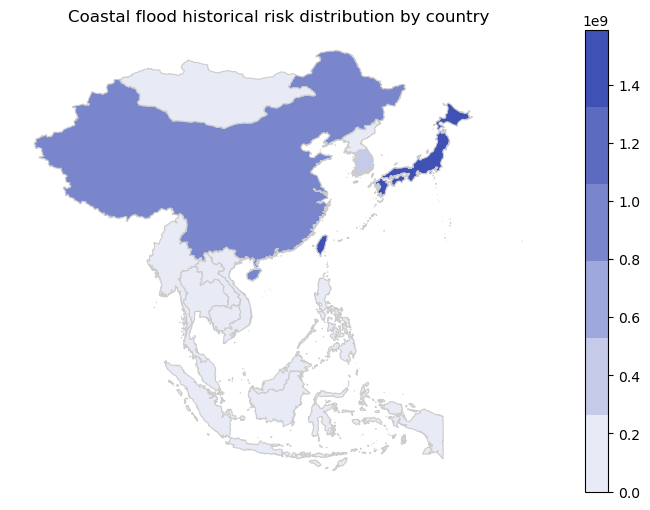

In [138]:
# With normalization
cmap = ListedColormap(['#E8EAF6', '#C5CAE9', '#9FA8DA', '#7986CB', '#5C6BC0', '#3F51B5'])
min_val = fl_hist['sum_risk'].min()
max_val = fl_hist['sum_risk'].max()
norm = Normalize(vmin=min_val, vmax=max_val)

fig, ax = plt.subplots(figsize=(10, 6))
fl_hist.plot(column='sum_risk', cmap=cmap, linewidth=0.8, ax=ax, edgecolor='0.8', norm=norm)

ax.set_title('Coastal flood historical risk distribution by country')
ax.set_axis_off()

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm)

plt.show()

In [129]:
# calculate relative change of risk
relative_change = ((fl_future.groupby('country_code')['sum_risk'].sum() - fl_hist.groupby('country_code')['sum_risk'].sum())
    / fl_hist.groupby('country_code')['sum_risk'].sum()) * 100

relative_risk = pd.DataFrame({
    'country_code': relative_change.index,
    'relative_change': relative_change.values
})

print(relative_risk)


   country_code  relative_change
0           BRN              NaN
1           CHN         1.705025
2           IDN         4.072803
3           JPN        -4.493193
4           KHM              NaN
5           KOR        -0.071896
6           LAO              NaN
7           MMR        56.449489
8           MNG              NaN
9           MYS        -2.647328
10          PHL        18.730491
11          PRK        36.110998
12          THA        -7.134854
13          TWN         8.204428
14          VNM        17.097631


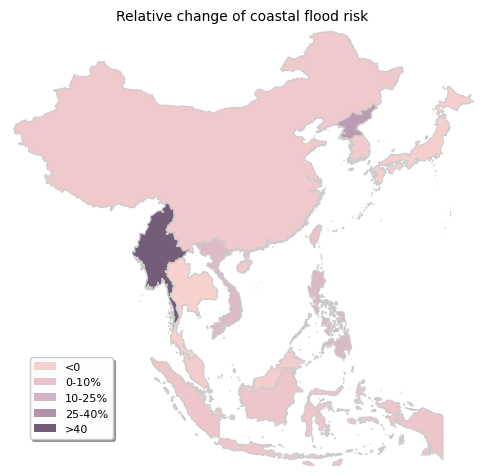

In [217]:
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Patch

fl_change_map = ne_countries.merge(relative_risk, left_on='SOV_A3', right_on='country_code', how='right')

fig, ax = plt.subplots(figsize=(6,6))

labels = [0,1,2,3,4,5]
label_names = ['<0','0-10%','10-25%','25-40%','>40']
color_scheme = ['#F7D1CD', '#E8C2CA', '#D1B3C4', '#B392AC', '#735D78']
#color_scheme =  ['#F6F6F7','#F2D7EE','#D3BCC0','#A5668B','#69306D','#0E103D']

cmap = LinearSegmentedColormap.from_list(name='continents',colors=color_scheme)
bins = [-10,0,10,20,40]

legend_elements = [Patch(facecolor=color_scheme[0],label=label_names[0]),
                   Patch(facecolor=color_scheme[1],label=label_names[1]),
                   Patch(facecolor=color_scheme[2],label=label_names[2]),
                   Patch(facecolor=color_scheme[3],label=label_names[3]),
                   Patch(facecolor=color_scheme[4],label=label_names[4])]
                   
legend = ax.legend(handles=legend_elements,shadow=True,fancybox=True,facecolor='#fefdfd',prop={'size':8},
                   loc='lower left',bbox_to_anchor=(0.03,0.05, 0.5, 0.5))

fl_change_map.plot(column='relative_change', linewidth=0.8, ax=ax, edgecolor='0.8', cmap=cmap) #, norm=norm

ax.set_title('Relative change of coastal flood risk',fontsize=10)
ax.set_axis_off()

ax.set_xlim(73,146)
ax.set_ylim(-10,54)

plt.show()

# current_xlim = ax.get_xlim()  # get the range of x
# current_ylim = ax.get_ylim()  # get the range of y

# print("Current x-axis range: ", current_xlim)
# print("Current y-axis range: ", current_ylim)